### Importing Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import cv2 as cv
import tensorflow as tf
import torch
import pickle
import zipfile
import os
import random
from PIL import Image

In [6]:
import ultralytics
from ultralytics import YOLO
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader

In [7]:
from moviepy import *

### Importing Necessary Models

In [8]:
yolo = YOLO('yolov8n.pt')

In [10]:
resnet = models.resnet50(pretrained = True)

In [11]:
num_classes = 3
resnet.fc = nn.Linear(resnet.fc.in_features,num_classes)

In [12]:
classes = yolo.names
res_class = {0:'Messi',2:'Ronaldo',1:'No Class'}

In [8]:
file = zipfile.ZipFile("./best.pt")
file.extractall()
file.close()

### Extracing frames from the video

In [37]:
direc = os.path.join('./Messi_Ronaldo.mp4')
video_pth = os.path.join('video_frames')
#video_pth = os.makedirs("video_frames")
cam = cv.VideoCapture(direc)
count = 0

while cam.isOpened():
    ret,frame = cam.read()
    cv.imwrite(os.path.join(video_pth,f'{count}.jpg'),frame)
    count += 1

cam.release()
cv.destroyAllWindows()

error: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:929: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


### Extrating audio from video

In [21]:
def video_audio(vid_pth,output_pth):
    video = VideoFileClip(vid_pth)
    audio = video.audio
    audio.write_audiofile(output_pth)

video_pth = os.path.join('Messi_Ronaldo.mp4')
output_pth = 'short_audio.mp3'
video_audio(video_pth,output_pth)

MoviePy - Writing audio in short_audio.mp3


MoviePy - Done.


In [39]:
print(os.listdir('./Player Dataset'))

['Messi', 'No_Class', 'Ronaldo']


### Creating seperate image arrays for each class

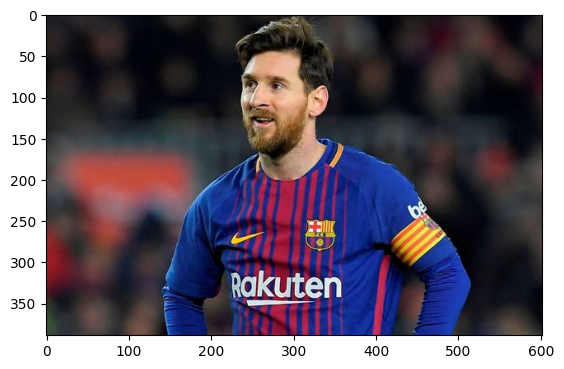

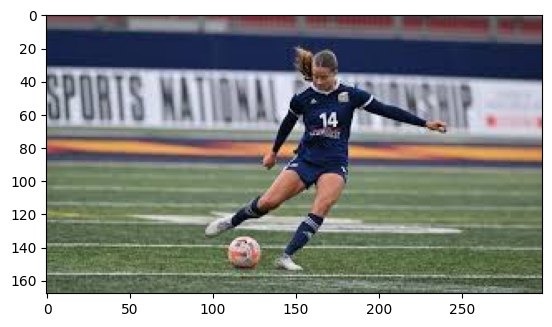

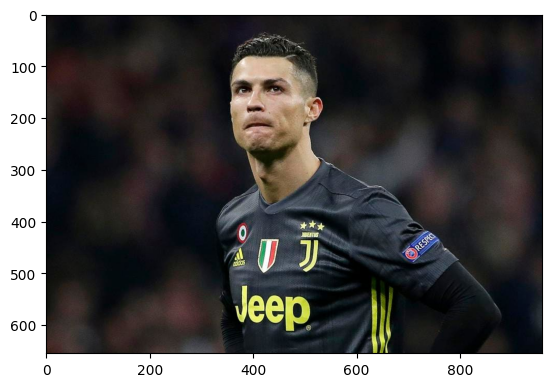

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.

In [43]:
data_pth = os.path.join('./Player Dataset')
ronaldo = []
messi = []
no_class = []

for i,data in enumerate(os.listdir(data_pth)):
    for j,img in enumerate(os.listdir(os.path.join(data_pth,data))):
        pth = os.path.join(data_pth,data)
        im = cv.imread(os.path.join(pth,img))
        im = cv.cvtColor(im,cv.COLOR_BGR2RGB)
        if data == 'Messi':
            messi.append(im)
        elif data == 'Ronaldo':
            ronaldo.append(im)
        else:
            no_class.append(im)
        if j == 1:
            plt.imshow(im)
            plt.show()

ronaldo = np.array(ronaldo)
messi = np.array(messi)
no_class = np.array(no_class)

### Creating Image paths and labels

In [16]:
img_pth = []
for pth in os.listdir('./Player Dataset'):
    im_pth = os.path.join('./Player Dataset',pth)
    for p in os.listdir(im_pth):
        img = os.path.join(im_pth,p)
        img_pth.append(img)

In [17]:
num_classes = 3
img_per_class = 20
labels = []
for cls in range(num_classes):
    labels.extend([cls]*img_per_class)

**Shuffling path and labels combined**

In [18]:
combined = list(zip(img_pth,labels))
random.shuffle(combined)
img_pth[:],labels[:] = zip(*combined)

### Creating dataset

In [14]:
class PlayerDataset(Dataset):
    def __init__(self,img_pth,labels,transforms = None):
        self.img_pth = img_pth
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.img_pth)
    def __getitem__(self,idx):
        img = Image.open(self.img_pth[idx]).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        label = self.labels[idx]
        return img,label

### Data Augmentation

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

### Loading data and Training Resnet model

In [19]:
dataset = PlayerDataset(img_pth,labels,transforms = train_transform)
loader = DataLoader(dataset,batch_size = 32,shuffle = True)

In [87]:
epochs = 16
resnet.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr = 0.001,weight_decay = 1e-3)

for epoch in range(epochs) :
  running_loss = 0
  for img,label in loader:
    img, label = img,label
    output = resnet(img)
    loss = criterion(output,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader)}')

Epoch 1/16, Loss: 0.7374477684497833
Epoch 2/16, Loss: 1.0064890384674072
Epoch 3/16, Loss: 1.143487960100174
Epoch 4/16, Loss: 0.7270379960536957
Epoch 5/16, Loss: 0.5673171579837799
Epoch 6/16, Loss: 0.5779797583818436
Epoch 7/16, Loss: 0.4449041932821274
Epoch 8/16, Loss: 0.4053286910057068
Epoch 9/16, Loss: 0.269329234957695
Epoch 10/16, Loss: 0.3320041000843048
Epoch 11/16, Loss: 0.23643086105585098
Epoch 12/16, Loss: 0.24293523281812668
Epoch 13/16, Loss: 0.17105118930339813
Epoch 14/16, Loss: 0.3757791519165039
Epoch 15/16, Loss: 0.2652379423379898
Epoch 16/16, Loss: 0.27108705043792725


**Testing the Resnet Performance**

In [19]:
path = os.path.join('/home/user/ronaldo.jpeg')
img = Image.open(path).convert('RGB')
img = test_transform(img)
img = img.unsqueeze(0)

In [20]:
result = resnet(img)
print(res_class[int(result.argmax())])

Ronaldo


**Saving and Loading the Resnet Model**

In [20]:
#torch.save(resnet.state_dict(),'Resnet_Player.pth')
resnet.load_state_dict(torch.load('Resnet_Player_1.pth'))

<All keys matched successfully>

**Testing YOLO performance on playgrounds**


0: 448x640 11 persons, 164.3ms
Speed: 3.6ms preprocess, 164.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


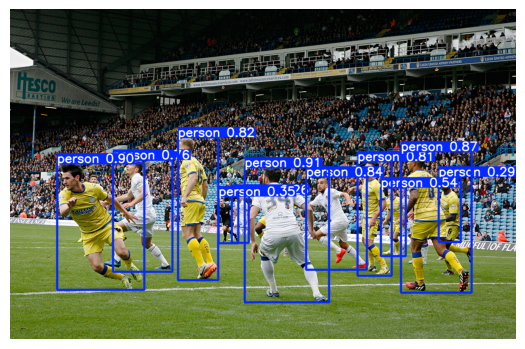

In [117]:
boxes = []
confidence_score = []
plt.figure(figsize = (30,40))
def img_counts(img_path):
    #for i, img in enumerate(os.listdir(img_path)):
    img = cv.imread(os.path.join(img_path))
    res = yolo(img)
    for r in res:
        for box in r.boxes:
            ind = int(box.cls)
            label = classes[ind]
            if label == 'person':
                boxes.append(box.data[:,:4])
                confidence_score.append(box.data[:,4])
        detect = r.plot()
        detect = cv.cvtColor(detect,cv.COLOR_BGR2RGB)
        plt.subplot(4,4,(i+1))
        plt.imshow(detect)
        plt.axis('off')
img_counts('/home/user/stadium.jpg')

### Extracting each person from each frame.
**Taken only one frame and one person**

In [139]:
img = cv.imread(os.path.join('/home/user/stadium.jpg'))
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
person_img = []
for box in boxes:
    x0,y0,x1,y1 = box[0]
    a = img[int(y0):int(y1),int(x0):int(x1)]
    person_img.append(a)

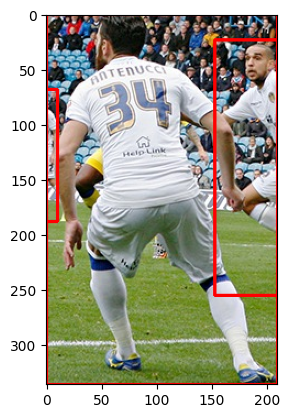

In [137]:
plt.imshow(img[394:730,584:794])

In [147]:
l = len(person_img)
for i,im in enumerate(person_img):
    im = Image.fromarray(im)
    im = test_transform(im).unsqueeze(0)
    result = resnet(im)
    #result = np.array(result)
    cls = result.argmax()
    print(result)

tensor([[-1.0900,  0.2156,  0.6796]], grad_fn=<AddmmBackward0>)
tensor([[-1.0981,  0.1477,  0.7423]], grad_fn=<AddmmBackward0>)
tensor([[-1.1670,  0.1943,  0.8076]], grad_fn=<AddmmBackward0>)
tensor([[-1.1116,  0.3037,  0.6258]], grad_fn=<AddmmBackward0>)
tensor([[-1.2758,  0.3202,  0.8038]], grad_fn=<AddmmBackward0>)
tensor([[-1.2062,  0.2736,  0.7656]], grad_fn=<AddmmBackward0>)
tensor([[-1.1939,  0.2235,  0.8129]], grad_fn=<AddmmBackward0>)
tensor([[-1.2781,  0.2866,  0.7965]], grad_fn=<AddmmBackward0>)
tensor([[-1.0880,  0.2823,  0.6709]], grad_fn=<AddmmBackward0>)
tensor([[-1.1805,  0.2698,  0.6822]], grad_fn=<AddmmBackward0>)
tensor([[-1.2150,  0.2772,  0.8198]], grad_fn=<AddmmBackward0>)


### Saving Detected images into another directory

In [21]:
frame_dir = 'video_frames'
frame_files = sorted(os.listdir(frame_dir), key=lambda x: int(os.path.splitext(x)[0]))
vid_dir = 'det_vid_frames_1'
#os.makedirs(vid_dir)

In [22]:
count = 0
for frame in frame_files:
    img = cv.imread(os.path.join(frame_dir,frame))
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    result = yolo(img)
    for r in result:
        for box in r.boxes:
            ind = int(box.cls)
            label = classes[ind]
            if label == 'person':
                b = box.xyxy[0]
                x1,y1,x2,y2 = map(int,b)
                c = box.data[:,4]
                if c >= 0.5:
                    im = img[y1:y2,x1:x2]
                    im = Image.fromarray(im)
                    im = test_transform(im).unsqueeze(0)
                    res = resnet(im)
                    out = res.argmax()
                    text = res_class[int(out)]
                    if text == 'Ronaldo':
                        cv.rectangle(img,(x1,y1),(x2,y2),(255,0,0),thickness = 2)
                        (text_w,text_h),baseline = cv.getTextSize(text,cv.FONT_HERSHEY_SIMPLEX,0.5,1)
                        cv.rectangle(img, (x1, y1 - text_h - 4), (x1 + text_w + 4, y1),(255,0,0), -1)
                        cv.putText(img, text, (x1 + 2, y1 - 4), cv.FONT_HERSHEY_SIMPLEX,
                            0.5, (255, 255, 255), thickness=1, lineType=cv.LINE_AA)
                    elif text == 'Messi':
                        cv.rectangle(img,(x1,y1),(x2,y2),(0,255,255),thickness = 2)
                        (text_w,text_h),baseline = cv.getTextSize(text,cv.FONT_HERSHEY_SIMPLEX,0.5,1)
                        cv.rectangle(img, (x1, y1 - text_h - 4), (x1 + text_w + 4, y1),(0,255,255), -1)
                        cv.putText(img, text, (x1 + 2, y1 - 4), cv.FONT_HERSHEY_SIMPLEX,
                            0.5, (255, 255, 255), thickness=1, lineType=cv.LINE_AA)
    cv.imwrite(os.path.join(vid_dir,f'{count}.jpg'),cv.cvtColor(img,cv.COLOR_RGB2BGR))
    count += 1
    print(f'frame_{count}.jpg saved')


0: 640x384 5 persons, 152.0ms
Speed: 4.8ms preprocess, 152.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)
frame_1.jpg saved

0: 640x384 5 persons, 141.5ms
Speed: 4.4ms preprocess, 141.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)
frame_2.jpg saved

0: 640x384 5 persons, 222.8ms
Speed: 5.5ms preprocess, 222.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)
frame_3.jpg saved

0: 640x384 5 persons, 138.5ms
Speed: 2.9ms preprocess, 138.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)
frame_4.jpg saved

0: 640x384 5 persons, 1 tennis racket, 131.3ms
Speed: 2.8ms preprocess, 131.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)
frame_5.jpg saved

0: 640x384 5 persons, 155.8ms
Speed: 2.8ms preprocess, 155.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)
frame_6.jpg saved

0: 640x384 4 persons, 149.4ms
Speed: 2.9ms preprocess, 149.4ms inference, 1.0ms postprocess per imag

### Creating a video out of detected frames

In [25]:
frame_files = sorted(os.listdir(vid_dir), key=lambda x: int(os.path.splitext(x)[0]))
height, width, _ = cv.imread(os.path.join(vid_dir, frame_files[0])).shape

out = cv.VideoWriter("Detected_video_1.mp4", cv.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

for frame in frame_files:
    img = cv.imread(os.path.join(vid_dir, frame))
    out.write(img)